In [4]:
import time
import logging
import os
import random
import csv

import numpy as np
import coloredlogs
from FAdo.conversions import *

from utils.data_loader import *
from utils.heuristics import *

from alpha_zero.Coach import Coach
from alpha_zero.MCTS import MCTS
from alpha_zero.utils import *
from alpha_zero.state_elimination.StateEliminationGame import StateEliminationGame as Game
from alpha_zero.state_elimination.pytorch.NNet import NNetWrapper as nn


In [5]:
log = logging.getLogger(__name__)
coloredlogs.install(level='INFO')
args = dotdict({
    'numIters': 1000,
    # Number of complete self-play games to simulate during a new iteration.
    'numEps': 100,
    'tempThreshold': 0,        # temperature hyperparameters
    # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'updateThreshold': 0.6,
    # Number of game examples to train the neural networks.
    'maxlenOfQueue': 200000,
    'numMCTSSims': 25,          # Number of games moves for MCTS to simulate.
    # Number of games to play during arena play to determine if new net will be accepted.
    'arenaCompare': 40,
    'cpuct': 1,
    'checkpoint': './alpha_zero/models/',
    'load_model': True,
    'load_folder_file': ('./alpha_zero/models/', 'best.pth.tar'),
    'numItersForTrainExamplesHistory': 20,
})
min_n = 3
max_n = 8
n_range = max_n - min_n + 1
alphabet = [2, 5, 10]
density = [0.2, 0.5]
sample_size = 30


In [16]:
def test_heuristics():
    if os.path.isfile('./result/heuristics_experiment_result.pkl'):
        with open('./result/heuristics_experiment_result.pkl', 'rb') as fp:
            exp = load(fp)
        for i in range(6):
            with open(f'./result/c{i + 1}.csv', 'w', newline='') as fp:
                writer = csv.writer(fp)
                for n in range(min_n - 3, max_n - 2):
                    size_value = exp[i][n][1][0][1] / 100
                    writer.writerow([size_value])
    else:
        data = load_data()
        exp = [[[[[0, 0] for d in range(len(density))] for k in range(
            len(alphabet))] for n in range(n_range)] for c in range(6)]
        for n in range(n_range):
            for k in range(len(alphabet)):
                for d in range(len(density)):
                    print('n' + str(n + min_n) + 'k' + ('2' if not k else ('5' if k == 1 else '10')) + (
                            's' if not d else 'd'))
                    for i in range(sample_size):
                        random.seed(i)
                        #print('n' + str(n + min_n) + 'k' + ('2' if not k else ('5' if k == 1 else '10')) + (
                        #    's' if not d else 'd') + '\'s ' + str(i + 1) + ' sample')
                        # eliminate_randomly
                        gfa = data[n][k][d][i].dup()
                        start_time = time.time()
                        result = eliminate_randomly(gfa)
                        end_time = time.time()
                        result_time = end_time - start_time
                        result_size = result.treeLength()
                        exp[0][n][k][d][0] += result_time
                        exp[0][n][k][d][1] += result_size

                        # decompose with eliminate_randomly
                        gfa = data[n][k][d][i].dup()
                        start_time = time.time()
                        result = decompose(gfa, False, False)
                        end_time = time.time()
                        result_time = end_time - start_time
                        result_size = result.treeLength()
                        exp[1][n][k][d][0] += result_time
                        exp[1][n][k][d][1] += result_size

                        # eliminate_by_state_weight_heuristic
                        gfa = data[n][k][d][i].dup()
                        start_time = time.time()
                        result = eliminate_by_state_weight_heuristic(gfa)
                        end_time = time.time()
                        result_time = end_time - start_time
                        result_size = result.treeLength()
                        exp[2][n][k][d][0] += result_time
                        exp[2][n][k][d][1] += result_size

                        # decompose + eliminate_by_state_weight_heuristic
                        gfa = data[n][k][d][i].dup()
                        start_time = time.time()
                        result = decompose(gfa, True, False)
                        end_time = time.time()
                        result_time = end_time - start_time
                        result_size = result.treeLength()
                        exp[3][n][k][d][0] += result_time
                        exp[3][n][k][d][1] += result_size

                        # eliminate_by_repeated_state_weight_heuristic
                        gfa = data[n][k][d][i].dup()
                        start_time = time.time()
                        result = eliminate_by_repeated_state_weight_heuristic(
                            gfa)
                        end_time = time.time()
                        result_time = end_time - start_time
                        result_size = result.treeLength()
                        exp[4][n][k][d][0] += result_time
                        exp[4][n][k][d][1] += result_size

                        # decompose + eliminate_by_repeated_state_weight_heuristic
                        gfa = data[n][k][d][i].dup()
                        start_time = time.time()
                        result = decompose(gfa, True, True)
                        end_time = time.time()
                        result_time = end_time - start_time
                        result_size = result.treeLength()
                        exp[5][n][k][d][0] += result_time
                        exp[5][n][k][d][1] += result_size
        with open('./result/heuristics_experiment_result.pkl', 'wb') as fp:
            dump(exp, fp)

        for i in range(6):
            with open(f'./result/c{i + 1}.csv', 'w', newline='') as fp:
                writer = csv.writer(fp)
                for n in range(min_n - 3, max_n - 2):
                    size_value = exp[i][n][1][0][1] / 100
                    writer.writerow([size_value])


In [17]:
exp = test_heuristics()

In [7]:
import pandas as pd

2023-03-10 21:05:58 ksk numexpr.utils[1670305] INFO Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-03-10 21:05:58 ksk numexpr.utils[1670305] INFO NumExpr defaulting to 8 threads.


In [8]:
def test_alpha_zero():
    if not os.path.isfile('./result/alpha_zero_experiment_result.pkl'):
        with open('./result/alpha_zero_experiment_result.pkl', 'rb') as fp:
            exp = load(fp)
        with open('./result/c7.csv', 'w', newline='') as fp:
            writer = csv.writer(fp)
            for n in range(min_n - 3, max_n - 2):
                size_value = exp[n][1][0][1] / 100
                writer.writerow([size_value])
    else:
        data = load_data()
        exp = [[[[0, 0] for d in range(len(density))] for k in range(
            len(alphabet))] for n in range(n_range)]
        g = Game()
        nnet = nn(g)
        mcts = MCTS(g, nnet, args)
        def player(x): return np.argmax(mcts.getActionProb(x, temp=0))
        curPlayer = 1
        if args.load_model:
            nnet.load_checkpoint(args.checkpoint, args.load_folder_file[1])
        else:
            print("Can't test without pre-trained model")
            exit()
        for n in range(n_range):
            for k in range(len(alphabet)):
                for d in range(len(density)):
                    for i in range(sample_size):
                        #print('n' + str(n + min_n) + 'k' + ('2' if not k else ('5' if k == 1 else '10')) + (
                        #    's' if not d else 'd') + '\'s ' + str(i + 1) + ' sample')
                        gfa = data[n][k][d][i].dup()
                        board = g.getInitBoard(
                            gfa, n + min_n, alphabet[k], density[d])
                        order = []
                        start_time = time.time()
                        while g.getGameEnded(board, curPlayer) == -1:
                            action = player(
                                g.getCanonicalForm(board, curPlayer))
                            valids = g.getValidMoves(
                                g.getCanonicalForm(board, curPlayer), 1)
                            if valids[action] == 0:
                                assert valids[action] > 0
                            board, curPlayer = g.getNextState(
                                board, curPlayer, action)
                            order.append(action)
                            
                        result = board[0][n + min_n + 1]
                        end_time = time.time()
                        gfa.eliminateAll(order)
                        if (result != gfa.delta[0][n + min_n + 1].treeLength()):
                            print('order', order)
                            print('result length', result)
                            print('valid length',
                                  gfa.delta[0][n + min_n + 1].treeLength())
                            print('Something is wrong')
                            exit()
                        result_time = end_time - start_time
                        exp[n][k][d][0] += result_time
                        exp[n][k][d][1] += result
        with open('./result/alpha_zero_experiment_result.pkl', 'wb') as fp:
            dump(exp, fp)
            
        with open('./result/c7.csv', 'w', newline='') as fp:
            writer = csv.writer(fp)
            for n in range(min_n - 3, max_n - 2):
                size_value = exp[n][1][0][1] / 100
                writer.writerow([size_value])


In [9]:
test_alpha_zero()

In [18]:
with open('./result/alpha_zero_experiment_result.pkl', 'rb') as fp:
    exp_alpha = load(fp)

with open('./result/heuristics_experiment_result.pkl', 'rb') as fp:
    exp_heuristic = load(fp)

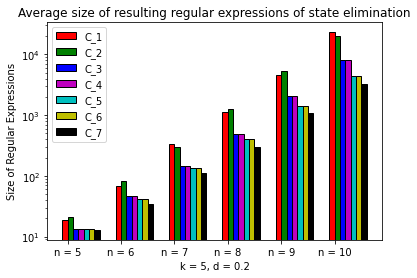

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import csv

n = 6
r = np.arange(n)
width = 0.10
x = []

for c in range(1, 8):
    file = open("./result/c" + str(c) + ".csv")
    temp = []
    for row in csv.reader(file):
        temp.append(row[0])
    temp = [float(i) for i in temp]
    x.append(temp)


plt.bar(r, x[0], color='r',
        width=width, edgecolor='black',
        label='C_1')

plt.bar(r + width, x[1], color='g',
        width=width, edgecolor='black',
        label='C_2')

plt.bar(r + width * 2, x[2], color='b',
        width=width, edgecolor='black',
        label='C_3')

plt.bar(r + width * 3, x[3], color='m',
        width=width, edgecolor='black',
        label='C_4')

plt.bar(r + width * 4, x[4], color='c',
        width=width, edgecolor='black',
        label='C_5')

plt.bar(r + width * 5, x[5], color='y',
        width=width, edgecolor='black',
        label='C_6')

plt.bar(r + width * 6, x[6], color='black',
        width=width, edgecolor='black',
        label='C_7')

plt.xlabel("k = 5, d = 0.2")
plt.ylabel("Size of Regular Expressions")
plt.title("Average size of resulting regular expressions of state elimination")

plt.xticks(r + width/2, ['n = 5', 'n = 6',
           'n = 7', 'n = 8', 'n = 9', 'n = 10'])
plt.yscale('log', base=10)

plt.legend()

plt.savefig('result.png', dpi=300)
plt.show()
